# Set up

In [0]:
# make sure it's python 3.5
import sys
sys.version_info >= (3,5)

# make sure it's sklearn 2.0 and later
import sklearn
sklearn.__version__ >= '0.20'

# common imports
import os
import numpy as np

# setting figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# saving figures
PROJECT_ROOT_DIR = '.'
PROJECT_ID = 'bank_debt_analysis'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', PROJECT_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, fig_extension='png', tight_layout=True, dpi=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print('Saving pictures: ', fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, dpi=dpi, format=fig_extension)

# Get data

In [0]:
import os
import urllib

# set up the directory
URL_PATH = 'https://raw.githubusercontent.com/AilingLiu/Which-Debts-Are-Worth-the-Bank-s-Effort/master/datasets/bank_data.csv'
DATA_PATH = os.path.join('datasets', 'bank_debt')

def fetch_data(url=URL_PATH, file_path=DATA_PATH):
  if not os.path.isdir(file_path):
    os.makedirs(file_path)
  path=os.path.join(file_path, 'bank_debt.csv')
  urllib.request.urlretrieve(url,path)

In [0]:
fetch_data()

In [0]:
import pandas as pd

def load_data():
  path = os.path.join(DATA_PATH, 'bank_debt.csv')
  return pd.read_csv(path)

In [5]:
debt = load_data()
debt.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# Quick look of data structure

From the top 5 rows, we can see there are 6 attributes: id, expected_recovery_amount, actual_recovery_amount, recovery_strategy, age, and sex.

In business sense, we should get some domain expert to explain each attributes. But this has been provided from the website where we donwload the data.

In [0]:
debt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1882 entries, 0 to 1881
Data columns (total 6 columns):
id                          1882 non-null int64
expected_recovery_amount    1882 non-null int64
actual_recovery_amount      1882 non-null float64
recovery_strategy           1882 non-null object
age                         1882 non-null int64
sex                         1882 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 88.3+ KB


## shape of data
There are 1882 rows, 6 attributes.

## data type
'recovery_strategy' and 'sex' are categorical attributes, thers are numerical values. Here, the 'id' column shouldn't be treated as numerical type.

## nonnull value status
None of the attribute appears to have missing values. We will examinate it carefully later on.

In [0]:
debt.recovery_strategy.value_counts()/len(debt)

Level 1 Recovery    0.356004
Level 3 Recovery    0.195537
Level 2 Recovery    0.176939
Level 4 Recovery    0.140276
Level 0 Recovery    0.131243
Name: recovery_strategy, dtype: float64

In [0]:
debt.describe()

,id,expected_recovery_amount,actual_recovery_amount,age
count,1882.000000,1882.000000,1882.000000,1882.000000
mean,1035.596174,2759.967588,4000.967837,39.650372
std,591.458429,2019.826565,4576.506350,15.453072
min,6.000000,194.000000,200.425000,18.000000
25%,534.250000,1261.250000,1045.190300,28.000000
50%,1029.500000,2062.000000,2115.446373,35.000000
75%,1551.750000,3569.500000,5417.237207,50.000000
max,2056.000000,9964.000000,34398.479710,84.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feb2805df60>,
      dtype=object)

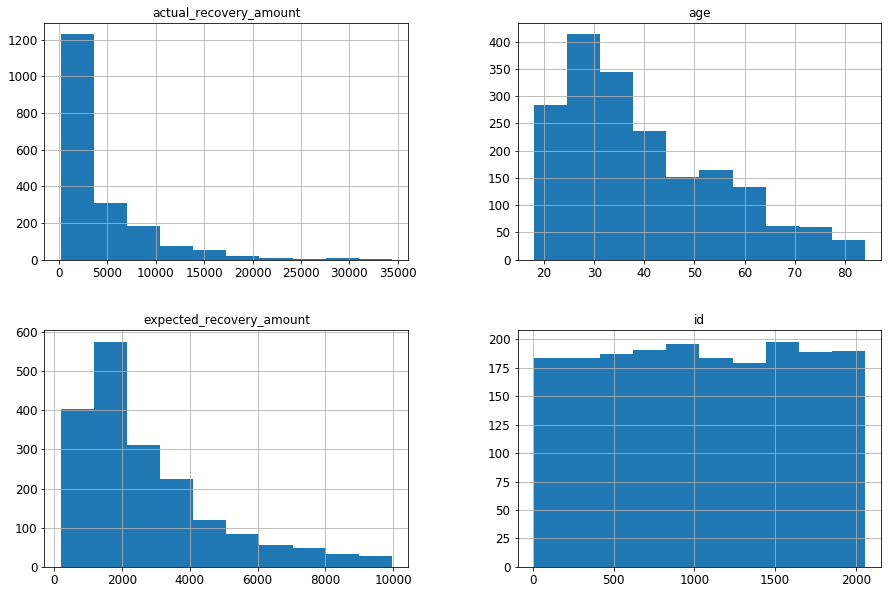

In [6]:
%matplotlib inline
debt.hist(figsize=(15, 10))

- We can see the three numerical attributes are all tail-heavy.
- The scale of these numerical values are different. Need to transform them to become more bell shape.
- No distinct outliers can be seen.

# split test set

In [0]:
import numpy as np
np.random.seed(42)

# generate stratified sampling using 'recovery_strategy'
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(debt, debt['recovery_strategy']):
  strat_train_set = debt.loc[train_index]
  strat_test_set = debt.loc[test_index]

In [8]:
strat_test_set['recovery_strategy'].value_counts()/len(strat_test_set)

Level 1 Recovery    0.355438
Level 3 Recovery    0.196286
Level 2 Recovery    0.177719
Level 4 Recovery    0.140584
Level 0 Recovery    0.129973
Name: recovery_strategy, dtype: float64

The stratified sampling has 'recovery_strategy' almost identical to those of full data.

# Discover and visualize data to gain insights

In [0]:
# back up the train set
payback = strat_train_set.copy()

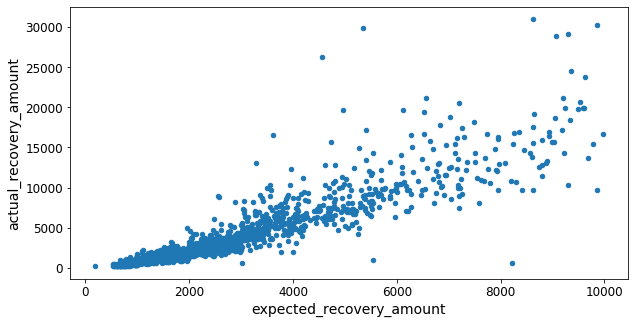

In [0]:
# visualize the ralationship between 'expected_recovery_amount' and 'actual_recovery_amount' in scatterplot
payback.plot(kind='scatter', x='expected_recovery_amount', y='actual_recovery_amount', figsize=(10, 5));

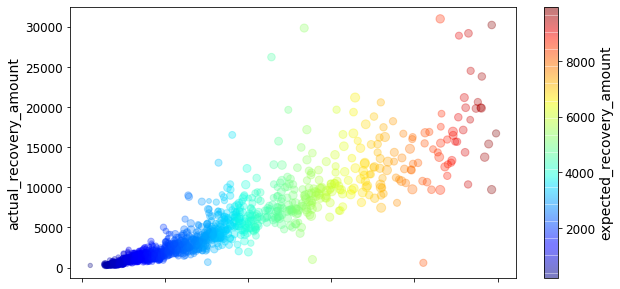

In [10]:
# format the style of the scatterplot
payback.plot(kind='scatter', x='expected_recovery_amount', y='actual_recovery_amount', figsize=(10, 5),
             alpha=0.3, s=payback['age'], c='expected_recovery_amount', cmap=plt.get_cmap('jet'), 
             colorbar=True, legend=True);


In [11]:
save_fig('expected_vs_actual_scatterplot', dpi=600)

Saving pictures:  expected_vs_actual_scatterplot


<Figure size 432x288 with 0 Axes>

This images tells that the 'actual_recovery_amount' are very much related to 'expected_recovery_amount'. The recovery amount is heavy in the lower end, along with scattered points at the hign end. Majority of the 'expected_recovery_amount' is below 5000 dollars.

# Looking for correlations

In [0]:
corr_matrix = payback.corr()

In [13]:
corr_matrix['actual_recovery_amount'].sort_values(ascending=False)

actual_recovery_amount      1.000000
expected_recovery_amount    0.905771
age                         0.718754
id                         -0.084204
Name: actual_recovery_amount, dtype: float64

It is not suprised that 'actual...' and 'expected' are positive highly correlated. The more it is expected, the more clients need to pay. What is interesting is 'age' is also relatively highly correlated to 'actual_...'. The older the client, the more likely their payment amount is high. This seems reasonable, as the senior clients are likely to ask for larger loans for more expensive products, such as house, cars, etc. 

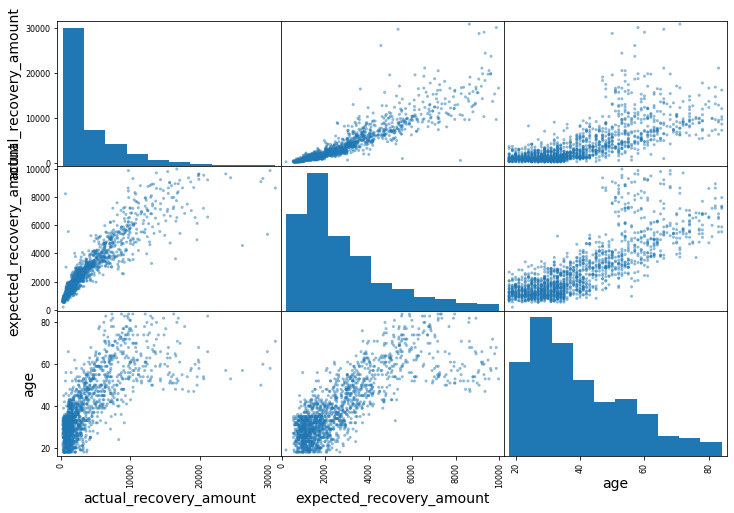

In [0]:
from pandas.plotting import scatter_matrix

num_attributes = ['actual_recovery_amount', 'expected_recovery_amount', 'age']

scatter_matrix(payback[num_attributes], figsize=(12, 8));

The correlation is indeed very strong. You can clearly see the upward trend. The points is more dispersed while age is beyond 50.

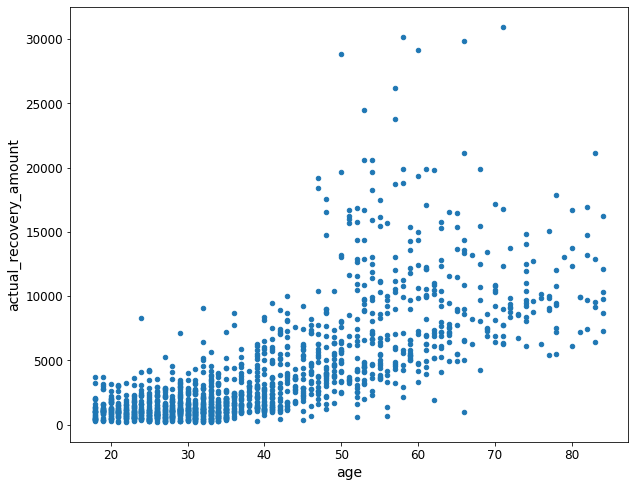

In [16]:
# Let's take a closer look of 'age' vs 'actual_recovery_amount'
payback.plot(kind='scatter', x='age', y='actual_recovery_amount', figsize=(10, 8));

For clients under 'age' 40, the relation is quite vague,  which means the 'actual_recovery_amount' can go from low (0) to about 5000 (top) randomly. After this gate, the points spersed with a number of outliers lurking above 25000 for few clients between 50 to 70. 

(0, 5000)

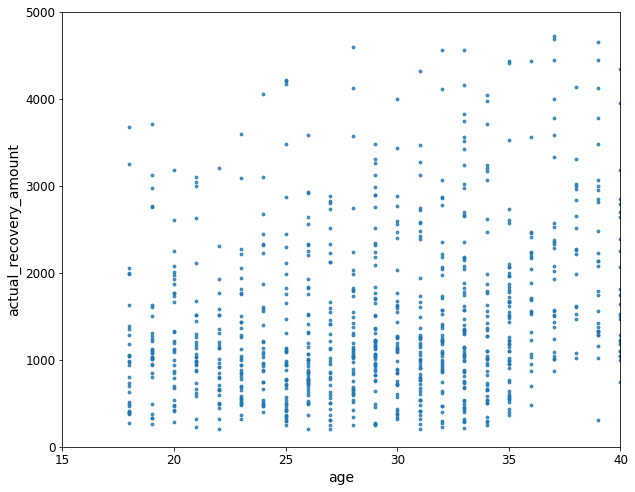

In [35]:
# let's format the graph

ax=payback.plot(kind='scatter', x='age', y='actual_recovery_amount', figsize=(10, 8),
             alpha=0.8, s=8);
ax.set_xlim((15, 40))
ax.set_ylim((0, 5000))

Statistical Test: Age vs Actual Recovery Amount

Since the `actual_recovery_amount` did not jump at 2000, we can set a threshold of 2000, where `<2k` and `>=2k` are split to mornitor if the age has an impact in this two group.

In [36]:
payback_0k_4k = payback.loc[(payback['actual_recovery_amount']<=4000)]
payback_0k_4k.groupby('recovery_strategy')['age'].describe().unstack()

       recovery_strategy
count  Level 0 Recovery     198.000000
       Level 1 Recovery     535.000000
       Level 2 Recovery     240.000000
       Level 3 Recovery      46.000000
       Level 4 Recovery       2.000000
mean   Level 0 Recovery      27.343434
       Level 1 Recovery      29.768224
       Level 2 Recovery      35.945833
       Level 3 Recovery      46.239130
       Level 4 Recovery      59.000000
std    Level 0 Recovery       5.828621
       Level 1 Recovery       6.984635
       Level 2 Recovery       8.945277
       Level 3 Recovery       7.882991
       Level 4 Recovery       9.899495
min    Level 0 Recovery      18.000000
       Level 1 Recovery      18.000000
       Level 2 Recovery      18.000000
       Level 3 Recovery      23.000000
       Level 4 Recovery      52.000000
25%    Level 0 Recovery      23.000000
       Level 1 Recovery      24.500000
       Level 2 Recovery      30.000000
       Level 3 Recovery      41.000000
       Level 4 Recovery      55.500000


In [42]:
payback_0k_4k['2k_gate']=pd.cut(payback['actual_recovery_amount'], bins=[0, 2000, 4000], labels=[2000, 4000])
payback_0k_4k.groupby('2k_gate')['actual_recovery_amount'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


2k_gate
2000    1998.850060
4000    3999.976012
Name: actual_recovery_amount, dtype: float64

In [45]:
from scipy.stats import kruskal
# Perform Kruskal-Wallis test 
Level_2k_age = payback_0k_4k.loc[payback_0k_4k['2k_gate']==2000]['age']
Level_4k_age = payback_0k_4k.loc[payback_0k_4k['2k_gate']==4000]['age']
kruskal(Level_2k_age,Level_4k_age)

KruskalResult(statistic=135.4345053802865, pvalue=2.6527522597895057e-31)

Indeed, there is no major jump in the average customer age just above and just below the \$2000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.